In [1]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

2024-07-05 18:36:47.852457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 18:36:47.852566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 18:36:47.994868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import optuna
study = optuna.create_study(direction="minimize")

[I 2024-07-05 18:37:01,563] A new study created in memory with name: no-name-dcd80105-e4e1-4ba3-962e-2dd753655ffd


In [3]:
df=pd.read_csv('/kaggle/input/mitre-dataset/Mitre_Website_Scraped - Mitre_Website_Scraped.csv')

In [4]:
df['id']=df.apply(lambda row: row['Technique'] if row['ID']=='No sub-Techniques' else row['ID'],axis=1)

In [5]:
df

,Unnamed: 0,Technique,ID,Tactic-Name,Technique-Name,SubTechnique-Name,Platforms,Description,id
0,0,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",admin@338 actors used the following command fo...,T1049
1,1,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",Andariel has used the netstat -naop tcp comman...,T1049
2,2,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT1 used the net use command to get a listing...,T1049
3,3,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT3 has a tool that can enumerate current net...,T1049
4,4,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT32 used the netstat -anpo tcp command to di...,T1049
...,...,...,...,...,...,...,...,...,...
11780,11780,T0827,No sub-Techniques,Impact,Loss of Control,No sub-Technique,NaN,"Provide operators with redundant, out-of-band ...",T0827
11781,11781,T0827,No sub-Techniques,Impact,Loss of Control,No sub-Technique,NaN,Hot-standbys in diverse locations can ensure c...,T0827
11782,11782,T0813,No sub-Techniques,Impact,Denial of Control,No sub-Technique,NaN,Take and store data backups from end user syst...,T0813
11783,11783,T0813,No sub-Techniques,Impact,Denial of Control,No sub-Technique,NaN,"Provide operators with redundant, out-of-band ...",T0813


In [6]:
df['count'] = df['Description'].apply(lambda x: len(x.split()))
df.head()

,Unnamed: 0,Technique,ID,Tactic-Name,Technique-Name,SubTechnique-Name,Platforms,Description,id,count
0,0,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",admin@338 actors used the following command fo...,T1049,22
1,1,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",Andariel has used the netstat -naop tcp comman...,T1049,16
2,2,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT1 used the net use command to get a listing...,T1049,13
3,3,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT3 has a tool that can enumerate current net...,T1049,10
4,4,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT32 used the netstat -anpo tcp command to di...,T1049,15


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Figure size 800x800 with 0 Axes>

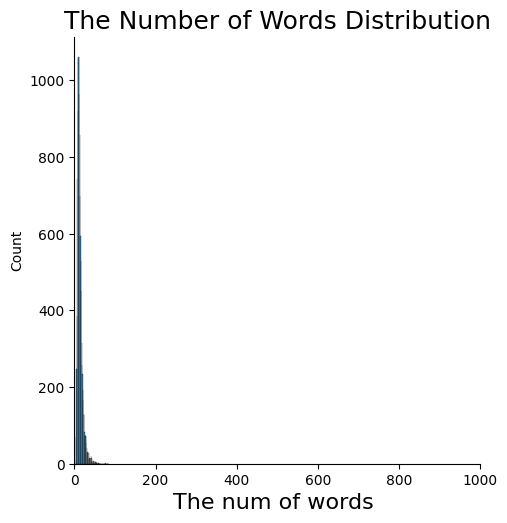

In [7]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [8]:
category_count = df['Tactic-Name'].value_counts()

categories = category_count.index

categories
category_count

Tactic-Name
Discovery                                                              2082
Defense Evasion                                                        2017
Command and Control                                                    1683
Execution                                                              1423
Collection                                                             1004
 Persistence, Privilege Escalation                                      472
Credential Access                                                       381
Resource Development                                                    313
Initial Access                                                          311
Exfiltration                                                            266
Impact                                                                  248
Lateral Movement                                                        203
 Defense Evasion, Privilege Escalation                                  164


In [9]:
category_count.index

Index(['Discovery', 'Defense Evasion', 'Command and Control', 'Execution',
       'Collection', ' Persistence, Privilege Escalation', 'Credential Access',
       'Resource Development', 'Initial Access', 'Exfiltration', 'Impact',
       'Lateral Movement', ' Defense Evasion, Privilege Escalation',
       ' Execution, Persistence, Privilege Escalation',
       ' Collection, Credential Access', 'Persistence',
       ' Defense Evasion, Discovery',
       ' Persistence, Privilege Escalation, Defense Evasion', 'Reconnaissance',
       ' Privilege Escalation, Persistence',
       ' Privilege Escalation, Defense Evasion', 'Collection, Discovery',
       ' Defense Evasion, Persistence, Privilege Escalation, Initial Access',
       'Privilege Escalation', ' Persistence, Initial Access',
       ' Defense Evasion, Lateral Movement', 'Credential Access, Collection',
       ' Lateral Movement, Initial Access', 'Collection, Credential Access',
       ' Credential Access, Discovery', ' Persistence, D

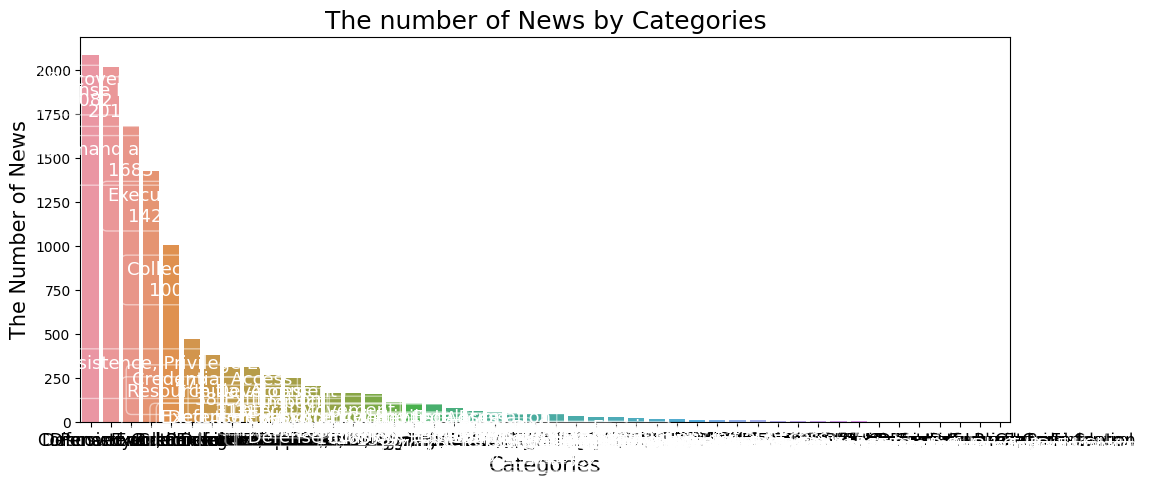

In [10]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Extract the features and the labels
X_data = df.drop(columns=['ID'])  # All columns except 'ID'
y_data = df['ID']  # The 'ID' column

# Combine the features and labels into a single DataFrame for easier processing
df_combined = df.copy()

# Function to manually split data ensuring each class is represented in both sets
def stratified_train_test_split(df, stratify_colname, test_size=0.3, seed=777):
    # Split the data
    df_train = pd.DataFrame(columns=df.columns)
    df_test = pd.DataFrame(columns=df.columns)
    
    np.random.seed(seed)
    for category in df[stratify_colname].unique():
        category_rows = df[df[stratify_colname] == category]
        test_size_category = int(len(category_rows) * test_size)
        test_indices = category_rows.sample(test_size_category).index
        train_indices = category_rows.drop(test_indices).index
        
        df_train = pd.concat([df_train, df.loc[train_indices]])
        df_test = pd.concat([df_test, df.loc[test_indices]])
    
    return df_train, df_test

# Perform the stratified split
train_df, test_df = stratified_train_test_split(df_combined, stratify_colname='ID', test_size=0.3, seed=777)

# Print the shapes to verify
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Verify distribution of categories
print("Training set category distribution:")
print(train_df['ID'].value_counts(normalize=True))

print("Test set category distribution:")
print(test_df['ID'].value_counts(normalize=True))

# Save the splits into CSV files
train_df.to_csv('/kaggle/working/train_data.csv', index=False)
test_df.to_csv('/kaggle/working/test_data.csv', index=False)

# Print confirmation
print("Training and test sets have been saved to 'train_data.csv' and 'test_data.csv' in the working directory.")# Save the training set to a CSV file
train_df.to_csv('train_set.csv', index=False)

# Save the testing set to a CSV file
test_df.to_csv('test_set.csv', index=False)

print("Training and testing sets have been saved to 'train_set.csv' and 'test_set.csv' respectively.")
print("Training and test sets have been saved to 'train_data.csv' and 'test_data.csv'.")

Training set shape: (8437, 10)
Test set shape: (3348, 10)
Training set category distribution:
ID
No sub-Techniques    0.403461
T1071.001            0.027379
T1059.003            0.026787
T1070.004            0.020268
T1547.001            0.018846
                       ...   
T1590.004            0.000119
T1218.009            0.000119
T1555.006            0.000119
T1593.002            0.000119
T1205.002            0.000119
Name: proportion, Length: 390, dtype: float64
Test set category distribution:
ID
No sub-Techniques    0.435484
T1071.001            0.029271
T1059.003            0.028674
T1070.004            0.021505
T1547.001            0.020311
                       ...   
T1630.001            0.000299
T1521.002            0.000299
T1550.001            0.000299
T1218.004            0.000299
T1562.002            0.000299
Name: proportion, Length: 218, dtype: float64
Training and test sets have been saved to 'train_data.csv' and 'test_data.csv' in the working directory.
Training an

In [12]:
id_counts = df['id'].value_counts().to_dict()

In [13]:
id_counts

{'T1105': 434,
 'T1082': 358,
 'T1071.001': 329,
 'T1059.003': 322,
 'T1083': 293,
 'T1057': 259,
 'T1070.004': 243,
 'T1140': 240,
 'T1547.001': 227,
 'T1033': 203,
 'T1005': 189,
 'T1059.001': 173,
 'T1106': 173,
 'T1036.005': 165,
 'T1204.002': 162,
 'T1041': 147,
 'T1573.001': 146,
 'T1053.005': 145,
 'T1113': 145,
 'T1112': 145,
 'T1056.001': 136,
 'T1566.001': 126,
 'T1543.003': 119,
 'T1059.005': 113,
 'T1047': 112,
 'T1012': 103,
 'T1132.001': 97,
 'T1074.001': 95,
 'T1218.011': 89,
 'T1049': 89,
 'T1027.002': 88,
 'T1018': 81,
 'T1588.002': 80,
 'T1562.001': 78,
 'T1036.004': 76,
 'T1124': 75,
 'T1095': 74,
 'T1555.003': 71,
 'T1204.001': 68,
 'T1566.002': 68,
 'T1573.002': 64,
 'T1553.002': 62,
 'T1636.004': 62,
 'T1007': 62,
 'T1055.001': 61,
 'T1003.001': 60,
 'T1135': 59,
 'T1027.010': 59,
 'T1560.001': 58,
 'T1569.002': 57,
 'T1046': 57,
 'T1574.002': 55,
 'T1497.001': 54,
 'T1119': 54,
 'T1548.002': 52,
 'T1486': 52,
 'T1203': 51,
 'T1008': 51,
 'T1087.001': 50,
 'T1071.

In [14]:
id_counts = test_df['id'].value_counts().to_dict()
id_counts

{'T1105': 138,
 'T1071.001': 98,
 'T1059.003': 96,
 'T1082': 94,
 'T1083': 87,
 'T1057': 75,
 'T1140': 72,
 'T1070.004': 72,
 'T1547.001': 68,
 'T1033': 59,
 'T1005': 56,
 'T1112': 52,
 'T1106': 51,
 'T1059.001': 51,
 'T1036.005': 49,
 'T1204.002': 48,
 'T1113': 45,
 'T1041': 45,
 'T1053.005': 43,
 'T1573.001': 43,
 'T1056.001': 40,
 'T1566.001': 37,
 'T1543.003': 35,
 'T1059.005': 33,
 'T1012': 30,
 'T1132.001': 29,
 'T1047': 29,
 'T1074.001': 28,
 'T1095': 26,
 'T1218.011': 26,
 'T1027.002': 26,
 'T1018': 25,
 'T1049': 24,
 'T1588.002': 24,
 'T1562.001': 23,
 'T1036.004': 22,
 'T1555.003': 21,
 'T1119': 21,
 'T1124': 21,
 'T1566.002': 20,
 'T1204.001': 20,
 'T1486': 20,
 'T1046': 19,
 'T1573.002': 19,
 'T1553.002': 18,
 'T1003.001': 18,
 'T1636.004': 18,
 'T1055.001': 18,
 'T1007': 17,
 'T1027.010': 17,
 'T1560.001': 17,
 'T1569.002': 17,
 'T1497.001': 16,
 'T1574.002': 16,
 'T1548.002': 15,
 'T1087.001': 15,
 'T1135': 15,
 'T1430': 15,
 'T1071.004': 15,
 'T1564.001': 14,
 'T1203': 1

In [15]:
id_counts = train_df['id'].value_counts().to_dict()
id_counts

{'T1105': 296,
 'T1082': 264,
 'T1071.001': 231,
 'T1059.003': 226,
 'T1083': 206,
 'T1057': 184,
 'T1070.004': 171,
 'T1140': 168,
 'T1547.001': 159,
 'T1033': 144,
 'T1005': 133,
 'T1106': 122,
 'T1059.001': 122,
 'T1036.005': 116,
 'T1204.002': 114,
 'T1573.001': 103,
 'T1053.005': 102,
 'T1041': 102,
 'T1113': 100,
 'T1056.001': 96,
 'T1112': 93,
 'T1566.001': 89,
 'T1543.003': 84,
 'T1047': 83,
 'T1059.005': 80,
 'T1012': 73,
 'T1132.001': 68,
 'T1074.001': 67,
 'T1049': 65,
 'T1218.011': 63,
 'T1027.002': 62,
 'T1018': 56,
 'T1588.002': 56,
 'T1562.001': 55,
 'T1036.004': 54,
 'T1124': 54,
 'T1555.003': 50,
 'T1566.002': 48,
 'T1095': 48,
 'T1204.001': 48,
 'T1573.002': 45,
 'T1007': 45,
 'T1553.002': 44,
 'T1636.004': 44,
 'T1135': 44,
 'T1055.001': 43,
 'T1003.001': 42,
 'T1027.010': 42,
 'T1560.001': 41,
 'T1569.002': 40,
 'T1574.002': 39,
 'T1008': 39,
 'T1497.001': 38,
 'T1046': 38,
 'T1548.002': 37,
 'T1203': 37,
 'T1087.001': 35,
 'T1120': 35,
 'T1426': 35,
 'T1071.004': 3

In [16]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder

# Load the training and testing datasets from CSV files
train_df = pd.read_csv('/kaggle/input/testing-and-training/train_data.csv')
test_df = pd.read_csv('/kaggle/input/testing-and-training/test_set (1).csv')

# Encode the alphanumeric IDs
label_encoder = LabelEncoder()
train_df['ID'] = label_encoder.fit_transform(train_df['ID'])
test_df['ID'] = label_encoder.transform(test_df['ID'])
# Extract texts and labels for training and testing sets
train_texts = train_df['Description'].values
train_labels = train_df['ID'].values
test_texts = test_df['Description'].values
test_labels = test_df['ID'].values

# Ensure the data is in the correct format (if needed)
train_texts = train_texts.tolist()
train_labels = train_labels.tolist()
test_texts = test_texts.tolist()
test_labels = test_labels.tolist()

In [17]:
# Tokenize the data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(64)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [18]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 3, 10)
    
    # Load the model
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Train the model
    model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=test_dataset)

    # Evaluate the model
    evaluation = model.evaluate(test_dataset)
    return evaluation[0]  # Return the loss for minimization

In [19]:
# Create an Optuna study and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=8)

# Best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Train and evaluate the model with the best hyperparameters
best_learning_rate = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]
best_epochs = best_params["epochs"]

[I 2024-07-05 18:37:25,777] A new study created in memory with name: no-name-cdff2648-e628-4022-b715-b1800f5bbda6


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1720204696.539900      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


528/528 [==============================] - 186s 246ms/step - loss: 4.0263 - accuracy: 0.4304 - val_loss: 5.9894 - val_accuracy: 0.0152
Epoch 2/10
528/528 [==============================] - 126s 239ms/step - loss: 3.2686 - accuracy: 0.4498 - val_loss: 5.2612 - val_accuracy: 0.0152
Epoch 3/10
528/528 [==============================] - 126s 239ms/step - loss: 2.7731 - accuracy: 0.4709 - val_loss: 4.7043 - val_accuracy: 0.0152
Epoch 4/10
528/528 [==============================] - 126s 239ms/step - loss: 2.4071 - accuracy: 0.5052 - val_loss: 4.5218 - val_accuracy: 0.4355
Epoch 5/10
528/528 [==============================] - 126s 239ms/step - loss: 2.2749 - accuracy: 0.5251 - val_loss: 4.4159 - val_accuracy: 0.4355
Epoch 6/10
528/528 [==============================] - 126s 239ms/step - loss: 2.1270 - accuracy: 0.5321 - val_loss: 4.5995 - val_accuracy: 0.4355
Epoch 7/10
528/528 [==============================] - 127s 240ms/step - loss: 2.0287 - accuracy: 0.5417 - val_loss: 4.8048 - val_accura

[I 2024-07-05 18:59:42,860] Trial 0 finished with value: 5.144704341888428 and parameters: {'learning_rate': 1.720944288140925e-05, 'batch_size': 16, 'epochs': 10}. Best is trial 0 with value: 5.144704341888428.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 mod

Epoch 1/3
528/528 [==============================] - 162s 250ms/step - loss: 4.5190 - accuracy: 0.3969 - val_loss: 6.0416 - val_accuracy: 0.0152
Epoch 2/3
528/528 [==============================] - 127s 240ms/step - loss: 3.5914 - accuracy: 0.4106 - val_loss: 5.3381 - val_accuracy: 0.0152
Epoch 3/3
53/53 [==============================] - 14s 260ms/step - loss: 4.7852 - accuracy: 0.3740


[I 2024-07-05 19:06:52,420] Trial 1 finished with value: 4.785248756408691 and parameters: {'learning_rate': 8.064096169367858e-06, 'batch_size': 16, 'epochs': 3}. Best is trial 1 with value: 4.785248756408691.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 mode

Epoch 1/8
528/528 [==============================] - 164s 251ms/step - loss: 4.9681 - accuracy: 0.3755 - val_loss: 5.6289 - val_accuracy: 0.0460
Epoch 2/8
528/528 [==============================] - 127s 241ms/step - loss: 3.8732 - accuracy: 0.4138 - val_loss: 5.0847 - val_accuracy: 0.4355
Epoch 3/8
528/528 [==============================] - 127s 240ms/step - loss: 3.4726 - accuracy: 0.4237 - val_loss: 5.0267 - val_accuracy: 0.4029
Epoch 4/8
528/528 [==============================] - 126s 239ms/step - loss: 3.3088 - accuracy: 0.4294 - val_loss: 4.9351 - val_accuracy: 0.0287
Epoch 5/8
528/528 [==============================] - 126s 239ms/step - loss: 3.1725 - accuracy: 0.4252 - val_loss: 4.7787 - val_accuracy: 0.0323
Epoch 6/8
528/528 [==============================] - 126s 239ms/step - loss: 3.3591 - accuracy: 0.4080 - val_loss: 4.7839 - val_accuracy: 0.0206
Epoch 7/8
528/528 [==============================] - 127s 240ms/step - loss: 3.2173 - accuracy: 0.4349 - val_loss: 4.7090 - val_ac

[I 2024-07-05 19:24:36,607] Trial 2 finished with value: 4.6830525398254395 and parameters: {'learning_rate': 4.372536516210882e-06, 'batch_size': 64, 'epochs': 8}. Best is trial 2 with value: 4.6830525398254395.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 mo

Epoch 1/8
528/528 [==============================] - 160s 249ms/step - loss: 4.0954 - accuracy: 0.4037 - val_loss: 6.0929 - val_accuracy: 0.0152
Epoch 2/8
528/528 [==============================] - 126s 239ms/step - loss: 3.2686 - accuracy: 0.4308 - val_loss: 5.5789 - val_accuracy: 0.0152
Epoch 3/8
528/528 [==============================] - 126s 239ms/step - loss: 2.8182 - accuracy: 0.4777 - val_loss: 4.9924 - val_accuracy: 0.0152
Epoch 4/8
528/528 [==============================] - 126s 239ms/step - loss: 2.4450 - accuracy: 0.5025 - val_loss: 4.7379 - val_accuracy: 0.0152
Epoch 5/8
528/528 [==============================] - 126s 239ms/step - loss: 2.2442 - accuracy: 0.5235 - val_loss: 4.7490 - val_accuracy: 0.0152
Epoch 6/8
528/528 [==============================] - 126s 239ms/step - loss: 2.1254 - accuracy: 0.5347 - val_loss: 4.8703 - val_accuracy: 0.0152
Epoch 7/8
528/528 [==============================] - 126s 239ms/step - loss: 2.0445 - accuracy: 0.5413 - val_loss: 4.8241 - val_ac

[I 2024-07-05 19:42:14,585] Trial 3 finished with value: 5.067263126373291 and parameters: {'learning_rate': 1.5008103588151086e-05, 'batch_size': 64, 'epochs': 8}. Best is trial 2 with value: 4.6830525398254395.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 mo

Epoch 1/4
528/528 [==============================] - 162s 250ms/step - loss: 4.4974 - accuracy: 0.3894 - val_loss: 5.8751 - val_accuracy: 0.0054
Epoch 2/4
528/528 [==============================] - 126s 239ms/step - loss: 3.5155 - accuracy: 0.4125 - val_loss: 5.3549 - val_accuracy: 0.4355
Epoch 3/4
528/528 [==============================] - 126s 239ms/step - loss: 3.1482 - accuracy: 0.4397 - val_loss: 4.7714 - val_accuracy: 0.4355
Epoch 4/4
53/53 [==============================] - 14s 260ms/step - loss: 4.7738 - accuracy: 0.4349


[I 2024-07-05 19:51:30,512] Trial 4 finished with value: 4.7737956047058105 and parameters: {'learning_rate': 8.386238711907175e-06, 'batch_size': 16, 'epochs': 4}. Best is trial 2 with value: 4.6830525398254395.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 mo

Epoch 1/9
528/528 [==============================] - 160s 250ms/step - loss: 5.5320 - accuracy: 0.3290 - val_loss: 5.0375 - val_accuracy: 0.4355
Epoch 2/9
528/528 [==============================] - 127s 240ms/step - loss: 4.7397 - accuracy: 0.4035 - val_loss: 4.9098 - val_accuracy: 0.4355
Epoch 3/9
528/528 [==============================] - 127s 240ms/step - loss: 4.3520 - accuracy: 0.4035 - val_loss: 5.0225 - val_accuracy: 0.4355
Epoch 4/9
528/528 [==============================] - 127s 240ms/step - loss: 4.1083 - accuracy: 0.4035 - val_loss: 4.9987 - val_accuracy: 0.4355
Epoch 5/9
528/528 [==============================] - 127s 240ms/step - loss: 3.9501 - accuracy: 0.4035 - val_loss: 4.9569 - val_accuracy: 0.4355
Epoch 6/9
528/528 [==============================] - 127s 240ms/step - loss: 3.9087 - accuracy: 0.4035 - val_loss: 4.8002 - val_accuracy: 0.4355
Epoch 7/9
528/528 [==============================] - 127s 240ms/step - loss: 3.8407 - accuracy: 0.4035 - val_loss: 4.6950 - val_ac

[I 2024-07-05 20:11:19,129] Trial 5 finished with value: 4.655451774597168 and parameters: {'learning_rate': 1.4066343765431838e-06, 'batch_size': 32, 'epochs': 9}. Best is trial 5 with value: 4.655451774597168.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 mod

Epoch 1/4
528/528 [==============================] - 163s 251ms/step - loss: 5.4733 - accuracy: 0.3613 - val_loss: 5.7934 - val_accuracy: 0.1995
Epoch 2/4
528/528 [==============================] - 127s 241ms/step - loss: 4.7369 - accuracy: 0.3988 - val_loss: 5.7620 - val_accuracy: 0.0624
Epoch 3/4
528/528 [==============================] - 127s 240ms/step - loss: 4.3317 - accuracy: 0.3947 - val_loss: 5.1671 - val_accuracy: 0.4355
Epoch 4/4
53/53 [==============================] - 14s 260ms/step - loss: 5.0421 - accuracy: 0.4355


[I 2024-07-05 20:20:37,317] Trial 6 finished with value: 5.0420637130737305 and parameters: {'learning_rate': 1.7953543465463796e-06, 'batch_size': 32, 'epochs': 4}. Best is trial 5 with value: 4.655451774597168.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 mo

Epoch 1/8
528/528 [==============================] - 160s 249ms/step - loss: 4.7219 - accuracy: 0.3856 - val_loss: 5.9804 - val_accuracy: 0.0152
Epoch 2/8
528/528 [==============================] - 126s 239ms/step - loss: 3.7344 - accuracy: 0.4186 - val_loss: 5.2728 - val_accuracy: 0.4352
Epoch 3/8
528/528 [==============================] - 126s 239ms/step - loss: 3.3200 - accuracy: 0.4311 - val_loss: 5.1101 - val_accuracy: 0.0203
Epoch 4/8
528/528 [==============================] - 126s 239ms/step - loss: 3.3005 - accuracy: 0.4285 - val_loss: 4.7687 - val_accuracy: 0.4355
Epoch 5/8
528/528 [==============================] - 126s 239ms/step - loss: 3.1695 - accuracy: 0.4318 - val_loss: 4.5582 - val_accuracy: 0.2375
Epoch 6/8
528/528 [==============================] - 126s 238ms/step - loss: 2.9520 - accuracy: 0.4449 - val_loss: 4.3925 - val_accuracy: 0.0203
Epoch 7/8
528/528 [==============================] - 126s 239ms/step - loss: 2.8086 - accuracy: 0.4598 - val_loss: 4.3744 - val_ac

[I 2024-07-05 20:38:15,334] Trial 7 finished with value: 4.3945112228393555 and parameters: {'learning_rate': 6.113776507764955e-06, 'batch_size': 32, 'epochs': 8}. Best is trial 7 with value: 4.3945112228393555.


Best hyperparameters:  {'learning_rate': 6.113776507764955e-06, 'batch_size': 32, 'epochs': 8}


In [20]:
# Create TensorFlow datasets with best batch size
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(best_batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(best_batch_size)

In [21]:
# Train the model with validation
print("Starting training with best hyperparameters...")
history = model.fit(train_dataset, epochs=best_epochs, validation_data=test_dataset)
print("Training completed.")

# Evaluate the model
print("Starting evaluation...")
evaluation = model.evaluate(test_dataset)
print(f"Evaluation results with best hyperparameters: {evaluation}")

Starting training with best hyperparameters...


NameError: name 'model' is not defined

In [ ]:
# Display training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()